<a href="https://colab.research.google.com/github/hbadawy/Kvasir/blob/main/Test4_Kvasir_Segmentation_using_U_Net0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d abdallahwagih/kvasir-dataset-for-classification-and-segmentation

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation
License(s): CC0-1.0
100% 1.19G/1.20G [00:12<00:00, 102MB/s] 
100% 1.20G/1.20G [00:12<00:00, 106MB/s]


In [ ]:
!unzip kvasir-dataset-for-classification-and-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/00687a70-bbad-4bf9-864f-9f7b3c27a2c8.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0134d93d-0922-4063-9acd-a4177f2b0c07.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/01f092a2-fccb-49f6-af06-8351c8bb47f1.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/022b40a7-a36f-4510-95a1-b6bb709e94ed.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02b1d319-dea6-418b-969a-c588585cb4f2.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/02de4b4c-8704-45f7-b90f-6004d76bdded.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/0339a2f7-65bb-41fb-8650-e119670b4e2e.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ccdf30-eac8-4e3b-b8e5-54fbf64709dd.jpg  
  inflating: kvasir-dataset/kvasir-dataset/esophagitis/03ea76c5-d60

In [ ]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
IMG_CHANNELS = 3
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
images_path = "/content/kvasir-seg/Kvasir-SEG/images"
mask_path = "/content/kvasir-seg/Kvasir-SEG/masks"

In [ ]:
img_ids = next(os.walk(images_path))[2]
mask_ids = next(os.walk(mask_path))[2]

In [ ]:
X = np.zeros((len(img_ids), 256, 256, 3), dtype=np.uint8)
y = np.zeros((len(mask_ids), 256, 256, 1), dtype=np.bool_)

In [ ]:
for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

In [ ]:
for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

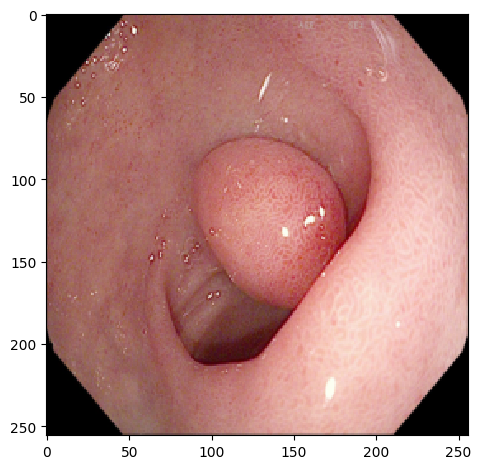

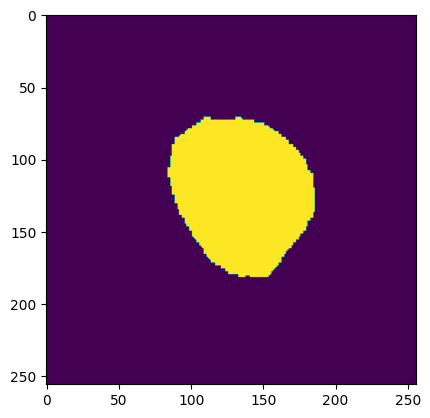

In [ ]:
image_random = random.randint(0, len(X))
imshow(X[image_random])
plt.show()
plt.imshow(np.squeeze(y[image_random]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print(f"X_train.shape: {X_train.shape}\nY_train.shape: {y_train.shape}")

X_train.shape: (670, 256, 256, 3)
Y_train.shape: (670, 256, 256, 1)


In [ ]:
print(f"X_test.shape: {X_test.shape}\nY_test.shape: {y_test.shape}")

X_test.shape: (330, 256, 256, 3)
Y_test.shape: (330, 256, 256, 1)


**MODEL:**
**UNet model for image segmentation [Semantic] : **



In [ ]:
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

model = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','iou_coef'])

In [ ]:
# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32) # Cast y_true to float32
    y_pred = tf.cast(y_pred, tf.float32) # Cast y_pred to float32
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef])

model.summary()

Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├──────────────────────

 Total params: 11,707,729 (44.66 MB)

 Trainable params: 11,707,729 (44.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=2)

Epoch 1/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 784s 10s/step - accuracy: 0.8147 - iou_coef: 0.1116 - loss: 0.5276 - val_accuracy: 0.8246 - val_iou_coef: 0.1377 - val_loss: 0.3981
Epoch 2/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 779s 10s/step - accuracy: 0.8252 - iou_coef: 0.1465 - loss: 0.4019 - val_accuracy: 0.8246 - val_iou_coef: 0.1371 - val_loss: 0.3938


**PREDICTED IMAGE:**

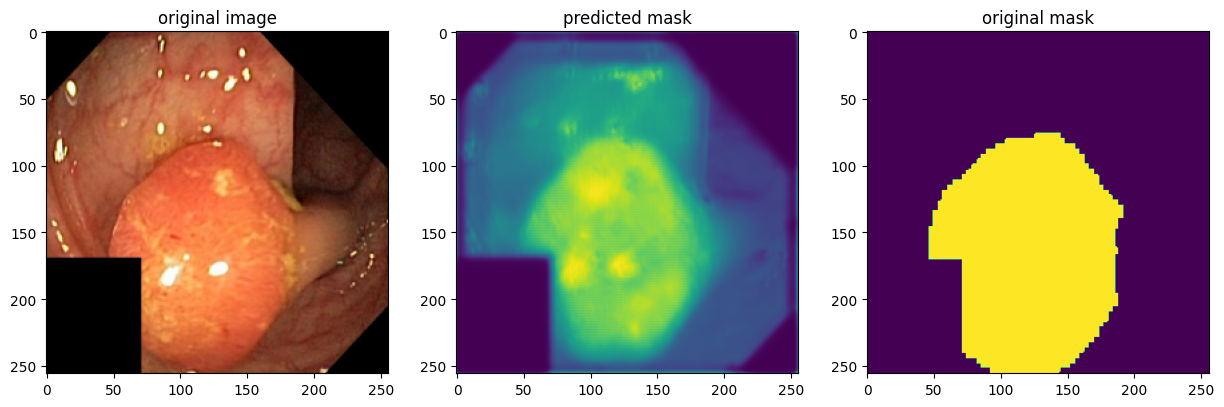

In [ ]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
msk = y_test[ind]
predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.title("original image")
plt.imshow(np.squeeze(img))
plt.subplot(1, 3, 2)
plt.title("predicted mask")
plt.imshow(np.squeeze(predictions))
plt.subplot(1, 3, 3)
plt.title("original mask")
#plt.imshow(np.squeeze(img))
#plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(msk))
# the original line is the following instead of the above
#plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.show()

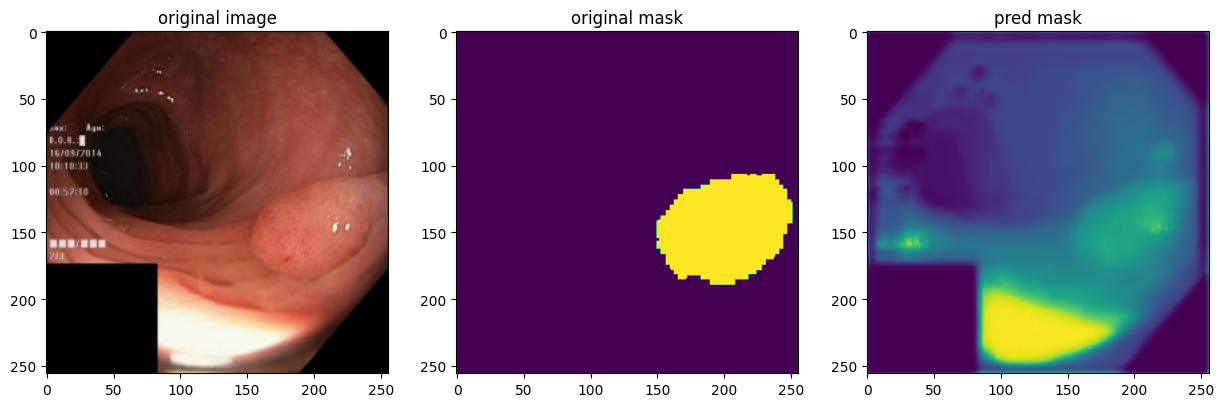

In [ ]:
ind = random.randint(0, len(X_test))
img = X_test[ind]
predMask = model.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image")
ax1.imshow(X_test[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask")
ax2.imshow(np.squeeze(y_test[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask")
ax3.imshow(np.squeeze(predMask))

In [ ]:
path_w = '/content/drive/MyDrive/Colab Notebooks/Weights_UNet_Kvasir.weights.h5' # Add .weights.h5 extension
model.save_weights(path_w)

In [ ]:
savedModel=load_model(path_w)
savedModel.summary()

ValueError: No model config found in the file at /content/drive/MyDrive/Colab Notebooks/Weights_UNet_Kvasir.weights.h5.